Steps:

1) Extract the dataset from the brw file. Voltage conversion and reshape into a 4096xnframes matrix

2) To identify if a recording presents some form of event that produces strong voltage variations in several contiguous channels, we use the following metric:

V = # different voltage values presents in one channel

From there, you make a Linear fitting (1-degree) of the data and obtain the confidence intervals form there.

The values above the confidence intervals are those channels that contain any number of voltage variations outside the non-tissue/noise behavior of the rest of the recording

At this point you just need the path to the folder contain the segments of the recording (each one with an 4096xnframes array, voltage converted, ~2 seconds total), and a Julia dictionary that contains the descriptive variables from the brw original file. 

In [5]:
PATHFunciones = "/home/LBitn/Desktop";
push!( LOAD_PATH, PATHFunciones ); 
using JuliaTools

In [17]:
# Package for manipulating jld files
using JLD
using StatsBase
using Measures
using BinningAnalysis
using Plots

FILEVars = "/home/LBitn/Data/Stimulo/Info/variablesBRW.jld";
PATHNoSat = "/home/LBitn/Data/Stimulo/Segments";

Variables = load( FILEVars )[ "Variables" ];
nChs = length( Variables[ "Layout" ] ); # total number of channels (...4096)

# function that reads files in a given path, gives an array of strings
FILESNoSat = searchdir( PATHNoSat, "jld" ); 

In [9]:
# Obtaining the variable V
i = 1

FILENoSat = FILESNoSat[ i ];

# The files are stored as Float16, but for some operations Float64 is needed
data = Float64.( load( FILENoSat )[ "data" ] ); 

V = zeros( Int, nChs ); # preallocation

for j = 1:nChs; V[ j ] = length( unique( data[ j, : ] ) ); end

Now V is a 4096 elements-vector of integers, each one with the number of voltage values in one channel

In [12]:
p = 0.9; # quantile value for the confidence interval calculation. 0.9 seems to fit just fine

xmean, Δx, C1, C2 = MeanΔxCI( V, p ); # mean, standard error, CI superior and CI inferior

Now, the channels with a value V above the CI are candidates for activity of interest. 
We took those channels and call a function that generate groups with the coordinates. Those channels in the 8-neighborhood are grouped together. The loose ones (one-member islands) are discarded in this particular process

In [13]:
AboveCI = findall( V .>= C1 ); 

grupos, loose = Get_Groups( AboveCI );

Here is where it becomes a little "It works, but I can't exactly point out why".

We can define 2 values that are going to show if a specific segment has a behavior that can be considered evidence of...synchronized channel superthreshold activity of some sort.

One is a "sparsity" mesure and the other is a form of "density" of the groups and how many of those are above the mean + 2 standard deviations.

If the second one is different than 0 (meaning there are groups with a "density" far away of a left centered normal distribution), that indicates that this segment has an abnormal behavior. In case of a control recording whit the green chips, this "density" vector is 0 in all the segments. 

If this is not the case, then we use the "sparsity" coefficient that helps with the identification of which of those segments of the entire pool have this behavior, and should be further addressed. 

So we applied these metrics for all the segments of one recording (~80 for a 3 minute recording)

In [ ]:
# All the mentioned metrics for all the segments of one recording. The results are storage into 2 Arrays
# for further analysis. This step takes a few minutes on an i9, 32GB RAM machine

nChs = length( Variables[ "Layout" ] ); # total number of channels (...4096)
p = 0.90;

sparsity_matrix = zeros( length( FILESNoSat ), 3 ); # Array n segments rows x 3 columns
variabilidades = zeros( nChs, length( FILESNoSat ) ); # Array 4096 rows x n segments columns

for i = 1:length( FILESNoSat );

    FILENoSat = FILESNoSat[ i ];
    
    data = Float64.( load( FILENoSat )[ "data" ] ); 

    V = zeros( Int, nChs ); # preallocation

    for j = 1:nChs; V[ j ] = length( unique( data[ j, : ] ) ); end

    xmean, Δx, C1, C2 = MeanΔxCI( V, p );
    
    AboveCI = findall( V .>= C1 ); 
    
    grupos, loose = Get_Groups( AboveCI );
    
    # Density, N channel above CI, Sparsity
    sparsity_matrix[ i, : ] = [ Density( grupos ), length( AboveCI ), Sparsity( length( grupos ), nChs ) ]
    
    # V vector of each segment into an array
    variabilidades[ :, i ] = V;
    
end

In [14]:
# save( "/home/LBitn/Data/Stimulo/Info/sparsity_matrix.jld", "data", sparsity_matrix );
# save( "/home/LBitn/Data/Stimulo/Info/variabilidades.jld", "data", variabilidades );
sparsity_matrix = load( "/home/LBitn/Data/Stimulo/Info/sparsity_matrix.jld" )["data"];
variabilidades = load( "/home/LBitn/Data/Stimulo/Info/variabilidades.jld" )["data"];

In [15]:
# Testing the Density values

if isempty( findall( sparsity_matrix[ :, 1 ] .== 0 ) )
    println("The experiment has no discharge-like events")
    permission = 0;
else
    println("Further analysis is needed")
    permission = 1;
end

if permission == 1

    S = sparsity_matrix[ :, 3 ];

    xmean, xerror = jackknife( identity, S );

    Potential_Discharge = findall( S .>= ( xmean + 2*std( S ) ) ); # Posible segments with discharge events 
    
end

Further analysis is needed


4-element Vector{Int64}:
  5
 33
 60
 72

In [20]:
# Ploting all the segments, quick check
Titles = replace.( basename.( FILESNoSat ), ".jld" => "" );

for i = 1:length( Titles )

    if !isempty( findall( i .== Potential_Discharge ) ) 
        
        T = string( Titles[ i ], " : positive for discharge" );
        
    else
        
        T = string( Titles[ i ], " : negative for discharge" );
        
    end

    W = variabilidades[ :, i ];
    Z = reverse( reshape( W, Variables[ "NRows" ], Variables[ "NCols" ] )', dims = 1 ); 
    
    FigureTest = Zplot( Z, :bwr );
    FigureTest = plot!( title = T, titlefont = ( 10, "arial" ) )
    
    figname = string( "/home/LBitn/Data/Stimulo/Figures/Detection/", Titles[ i ], ".png" );
    savefig( FigureTest, figname )
    
end

In this specific case, we can conclude from the figures that the segments 5, 33 and 60 certainly have discharge events. The density test offers segments 33 and 60, the sparsity test results in segments 5, 33, 60 and 72. 
We always took the sparsity test moving forward.

3) Now, with the segments identified, we have to extract the exact frames where the discharge events had been recorded

In [21]:
# Noise-adaptive Optimal Thresholding
@inline donoho( x ) =  ( median( abs.( x ) ) / 0.6745 );
σ = 5; # Ideally 4/√3, but we are looking for supra supra threshold events, so a larger σ is needed.
channels = 1:nChs;

In [22]:
I = 1

FILENoSat = FILESNoSat[ Potential_Discharge[ I ] ];

data = Float64.( load( FILENoSat )[ "data" ] ); 

allframes = [ ];

for j = 1:size( data, 1 )
    
    # Only positive side of the thresholding, to avoid detecting possible spikes
    thr = σ*donoho( data[ j, : ] ); 
    
    upperframes = findall( data[ j, : ] .> thr );
    
    push!( allframes, upperframes )
    
end

The new vector is the number of frames suprathreshold. This vector has a clear lineal behavior whit a low number of outliers. With this, just the values above the mean is sufficient for detecting the protruding channels

In [23]:
FirstDetection = channels[ length.( allframes ) .>= mean( length.( allframes ) ) ];

allsatframes = vcat( allframes[ FirstDetection ]...); Temporal = countmap( allsatframes );

canal_virtual = zeros( Int, size( data, 2 ) );

k = Int.( keys( Temporal ) ); v = Int.( values( Temporal ) );

for i = 1:length( k )
    
    canal_virtual[ k[ i ] ] = v[ i ];
    
end

From this virtual channel, we again took a threshold to detect the incredibly high repeated frames in order to avoid false positives

In [24]:
thr = 2*σ*donoho( canal_virtual ); Finals = findall( canal_virtual .>= thr );

In this specific case, we know that the 72 segment does not have discharge events. We can avoid following through with the next steps here, checking the number of "Finals" frames detected.

Segment 05 = 208 possible frames detected for repair
Segment 33 = 159
Segment 60 = 211
Segment 72 = 0

And now, having the possible frames, we check that the crossing the threshold is in both directions, condition that is needed to discard possible action potentials

In [25]:
upstairs = [ ]; downstairs = [ ];
for i = 1:nChs

    A = σ*donoho( data[ i, : ] ); B = -σ*donoho( data[ i, : ] );

    a = findall( data[ i, Finals ] .> A ); b = findall( data[ i, Finals ] .< B );

    if !isempty( a ) || !isempty( b )
        
        if !isempty( a )
            
            push!( upstairs, a )
            
        else
            
            push!( upstairs, 0 )
            
        end
        if !isempty( b )
            
            push!( downstairs, b )
            
        else
            
            push!( downstairs, 0 )
            
        end
        
    elseif isempty( a ) && isempty( b )
        
        push!( downstairs, 0 )
        
        push!( upstairs, 0 )
        
    end
end

All the following is just for checking the detected contaminated channels based on the potential contaminated frames. There is no need to plot this, just for proper visualization

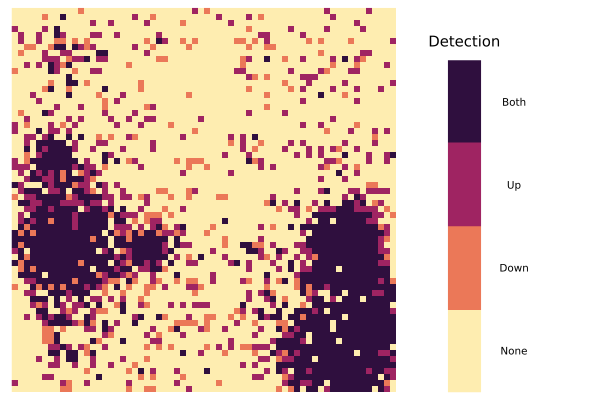

In [26]:
Z = zeros( Int, nChs );
Z[ findall( downstairs .!= 0 ) ] .= 1
Z[ findall( upstairs .!= 0 ) ] .= 2
Z[ intersect( findall( downstairs .!= 0 ), findall( upstairs .!= 0 ) ) ] .= 3;
Z = reverse( reshape( Z, Variables[ "NRows" ], Variables[ "NCols" ] )', dims = 1 ); 

labels = ["None","Down", "Up", "Both"];

n = 4;
yt = range( 0, 1, n + 1 )[ 1:n ] .+ 0.5/n;

l = @layout [ a{ 0.80w } [ b{ 0.1h }; c ] ];
colors = cgrad( :matter, n, categorical = true);

p1 = heatmap( Z, color = colors,  cbar = false, aspect_ratio = 1 );

p2 = plot( [ NaN ], lims = ( 0, 1 ), framestyle = :none, legend = false);
annotate!( 0.5, 0.1, text( "Detection", 10, "Arial" ) );

xx = range( 0, 1, 100 ); zz = zero( xx )' .+ xx;

p3 = heatmap( xx, xx, zz, ticks = false, ratio = 10, legend = false, fc = colors, lims = ( 0, 1 ),
             framestyle = :box, right_margin = 20mm );
[ annotate!( 2, yi, text( ti, 7, "Arial" ) ) for ( yi, ti ) in zip( yt, labels ) ]
plot( p1, p2, p3, layout = l, margins = 0mm, axis = ( [ ], false ) )

In [27]:
# channels for repairing
channels4patchup = intersect( findall( downstairs .!= 0 ), findall( upstairs .!= 0 ) );

4) Now, having a list of contaminated channels and frames, we just have to replace those values whit a value that represents the global activity of the no-saturated electrodes

In [64]:
# First, we discard the saturated values due the amplifiers

data_reparado = copy( data );
data_reparado[ data .<= ( Variables[ "MinVolt" ][ ] + 1 ) ] .= 0;
data_reparado[ data .>= ( Variables[ "MaxVolt" ][ ] - 1 ) ] .= 0;

The events occur in 4 rapid successions of discharges. We find the frames that comprise each individual discharge

In [ ]:
nsteps = 4;

SamplingRate = Variables[ "SamplingRate" ][ 1 ];

temp = Finals[ 2:end ] .- Finals[ 1:( end - 1 )];

steps = temp[ findall( Finals[ 2:end ] .- Finals[ 1:( end - 1 ) ] .> ms2frames( 5, SamplingRate ) ) ];

firstlast = Finals[ 1:( end - 1 ) ][ findall( Finals[ 2:end ] .- Finals[ 1:( end - 1 ) ] .> ms2frames( 5, SamplingRate ) ) ];

segmentos = Array{ Any }( nothing, 4 );
segmentos[ 1 ] = Finals[ firstlast[ 1 ] .>= Finals .>= minimum( Finals ) ]; # first segment
segmentos[ 2 ] = Finals[ firstlast[ 2 ] .>= Finals .> firstlast[ 1 ] ];
segmentos[ 3 ] = Finals[ firstlast[ 3 ] .>= Finals .> firstlast[ 2 ] ];
segmentos[ 4 ] = Finals[ maximum( Finals ) .>= Finals .> firstlast[ 3 ] ];

S1 = ( 
    minimum( 
        segmentos[ 1 ] ) - ms2frames( 
        1, SamplingRate ) ):( maximum( segmentos[ 1 ] ) + ms2frames( 1, SamplingRate ) );

S2 = ( 
    minimum( 
        segmentos[ 2 ] ) - ms2frames( 
        1, SamplingRate ) ):( maximum( segmentos[ 2 ] ) + ms2frames( 1, SamplingRate ) );

S3 = ( 
    minimum( 
        segmentos[ 3 ] ) - ms2frames( 
        1, SamplingRate ) ):( maximum( segmentos[ 3 ] ) + ms2frames( 1, SamplingRate ) );

S4 = ( 
    minimum( 
        segmentos[ 4 ] ) - ms2frames( 
        1, SamplingRate ) ):( maximum( segmentos[ 4 ] ) + ms2frames( 1, SamplingRate ) );

TotalFrames = vcat( S1, S2, S3, S4 );

Now we have the frames, the channels, time to fix the recording

In [123]:
aux = union( 1:minimum( TotalFrames ), maximum( TotalFrames ):size( data, 2 ) );

window = 10; # msec
window = ms2frames( window, SamplingRate );

for i = 1:length( channels4patchup )
    for j = 1:length( TotalFrames )
        data_reparado[ channels4patchup[ i ], TotalFrames[ j ] ] = 
            mode( data_reparado[ channels4patchup[ i ], sample( aux, window ) ] );
    end
end

Here you can use wherever value you consider proper. The simple mean does not seem to do the trick due the high value of the saturations even when there are just a few channels to fix. So, I again suggest the mode of the channel inside a random x-ms window outside the saturated region.

For visualization:

In [124]:
ncanal = sample( channels4patchup );

P1 = plot( data[ ncanal, : ], lab = string("channel: ", ncanal) );

P2 = plot( data[ ncanal, : ], lab = :none );

P2 = vline!( [ TotalFrames ], lab = "eventos" );

P3 = plot( data_reparado[ ncanal, : ], lab = "reparado" );

Figura2 = plot( P1, P2, P3, layout = ( 3, 1 ), wsize = ( 900, 600 ) )

In [125]:
i = Potential_Discharge[ I ];
W = variabilidades[ :, i ];

Z = reverse( reshape( W, Variables[ "NRows" ], Variables[ "NCols" ] )', dims = 1 ); 
T = string(Titles[ i ], " original");

plot()
FO = Zplot2( Z, :bwr );
FO = plot!( title = T, titlefont = ( 10, "arial" ) );

V = zeros( Int, nChs ); # preallocation
for j = 1:nChs; V[ j ] = length( unique( data_reparado[ j, : ] ) ); end
W = V;
Z = reverse( reshape( W, Variables[ "NRows" ], Variables[ "NCols" ] )', dims = 1 ); 
T = string(Titles[ i ], " repaired")
plot()
FR = Zplot2( Z, :bwr );
FR = plot!( title = T, titlefont = ( 10, "arial" ) );

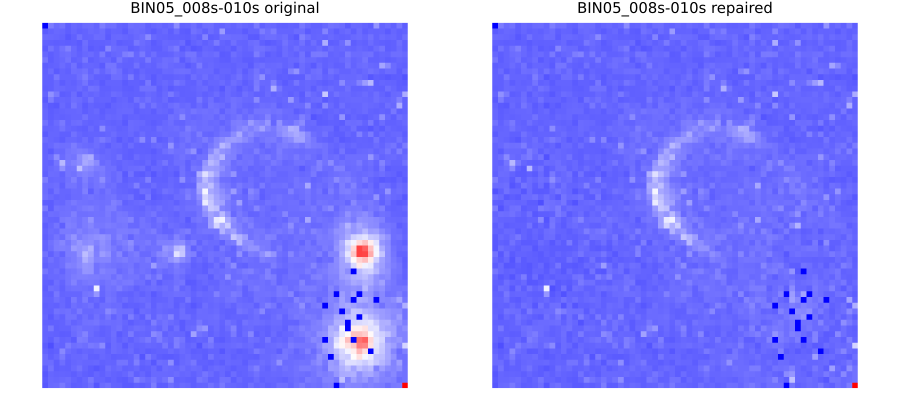

In [126]:
plot( FO, FR, layout = ( 1, 2 ), wsize = ( 900, 400 ))

5) Now we have the patch up segment, save and repeat for all the others Potential_Discharge segments detected

In [ ]:
save( replace(FILENoSat, "BIN" => "Rep_BIN"), "data", data_reparado );